In [1]:
! nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-788e3b20-8b2b-9dce-7f3d-65e707b02713)


In [2]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


In [3]:
!git clone https://github.com/SkalskiP/yolov9.git

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325
Receiving objects: 100% (325/325), 2.25 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [4]:
!pip install -r /kaggle/working/yolov9/requirements.txt -q

In [5]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [6]:
!pip install fiftyone > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.1 requires botocore<1.34.52,>=1.34.41, but you have botocore 1.29.165 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
apache-beam 2.46.0 requires pymongo<4.0.0,>=3.8.0, but you have pymongo 4.6.3 which is incompatible.
ydata-profiling 4.6.4 requires dacite>=1.8, but you have dacite 1.7.0 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [7]:
import fiftyone as fo
import fiftyone.utils.ultralytics as fou
import fiftyone.zoo as foz
from fiftyone import ViewField as F

ds_train = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    dataset_name="COCO-2017-train",
    label_types=["detections"],
    classes=["person"],
    shuffle=True,
    dataset_dir='./data',
    max_samples=4000,
    seed=43
)

ds_val = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    dataset_name="COCO-2017-val",
    label_types=["detections"],
    classes=["person"],
    shuffle=True,
    dataset_dir='./data',
    max_samples=500,
    seed=43
)

ds_test = foz.load_zoo_dataset(
    "coco-2017",
    split="test",
    dataset_name="COCO-2017-test",
    label_types=["detections"],
    classes=["person"],
    #shuffle=True,
    dataset_dir='./data',
    max_samples=500,
    seed=43
)

Migrating database to v0.23.7
 100% |██████|    1.9Gb/1.9Gb [4.6s elapsed, 0s remaining, 469.8Mb/s]       
Extracting annotations to 'data/raw/instances_train2017.json'
 100% |████████████████| 4000/4000 [6.8m elapsed, 0s remaining, 9.4 images/s]       
Writing annotations for 4000 downloaded samples to './data/train/labels.json'
Dataset info written to './data/info.json'
Loading 'coco-2017' split 'train'
 100% |███████████████| 4000/4000 [35.3s elapsed, 0s remaining, 123.6 samples/s]      
Dataset 'COCO-2017-train' created
Found annotations at 'data/raw/instances_val2017.json'
 100% |██████████████████| 500/500 [52.6s elapsed, 0s remaining, 8.3 images/s]      
Writing annotations for 500 downloaded samples to './data/validation/labels.json'
Dataset info written to './data/info.json'
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 500/500 [4.5s elapsed, 0s remaining, 122.1 samples/s]      
Dataset 'COCO-2017-val' created
Test split is unlabeled; ignoring classes requir

In [8]:
def pickPersonLabel(dataset):
  # Iterate over the dataset
  for sample in dataset:
      # Get the detections
      detections = sample.ground_truth.detections
      # Filter out non-person detections
      detections = [d for d in detections if d.label == "person"]
      # Update the detections
      sample.ground_truth.detections = detections
      # Save the sample
      sample.save()

pickPersonLabel(ds_train)
pickPersonLabel(ds_val)

train_classes = ds_train.distinct("ground_truth.detections.label")
val_classes = ds_val.distinct("ground_truth.detections.label")
test_classes = ds_test.distinct("ground_truth.detections.label")
print("train classes:", train_classes)
print("val classes:", val_classes)
print("test classes:", test_classes)
print(len(ds_train))
print(len(ds_val))
print(len(ds_test))

train classes: ['person']
val classes: ['person']
test classes: []
4000
500
500


In [9]:
# The path to export the dataset
EXPORT_DIR = f"{HOME}/tmp/YOLOv5Dataset" 

# YOLO format requires a common classes list
classes = train_classes

ds_train.export(
    export_dir=EXPORT_DIR,
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="ground_truth",
    split="train",
    classes=classes,
)

ds_val.export(
    export_dir=EXPORT_DIR,
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="ground_truth",
    split="validation",
    classes=classes,
)

ds_test.export(
    export_dir=EXPORT_DIR,
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="ground_truth",
    split="test",
    classes=classes,
)

 100% |███████████████| 4000/4000 [10.2s elapsed, 0s remaining, 389.2 samples/s]      
Directory '/kaggle/working/tmp/YOLOv5Dataset' already exists; export will be merged with existing files
 100% |█████████████████| 500/500 [1.3s elapsed, 0s remaining, 382.3 samples/s]         
Directory '/kaggle/working/tmp/YOLOv5Dataset' already exists; export will be merged with existing files
 100% |█████████████████| 500/500 [365.1ms elapsed, 0s remaining, 1.4K samples/s]      


In [31]:
!head -n 100 /kaggle/working/tmp/YOLOv5Dataset/dataset.yaml

names:
  0: person
path: /kaggle/working/tmp/YOLOv5Dataset
test: ./images/test/
train: ./images/train/
validation: ./images/validation/


In [11]:
%%time

! pip install --upgrade ultralytics -qq

CPU times: user 168 ms, sys: 50.3 ms, total: 218 ms
Wall time: 13.7 s


In [12]:
import ultralytics
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [13]:
!wandb disabled

W&B disabled.


In [48]:
class CFG:
    DEBUG = True
    FRACTION = 1.0#0.05 if DEBUG else 1.0
    SEED = 43

    # classes
    CLASSES = ['person']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70 # 100
    BATCH_SIZE = 8
    
    BASE_MODEL = 'yolov9c' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'person_detection_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = f'{HOME}/tmp/YOLOv5Dataset'
    OUTPUT_DIR = f'{HOME}/tmp/YOLOv5Dataset'

In [15]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (360, 640, 3) 



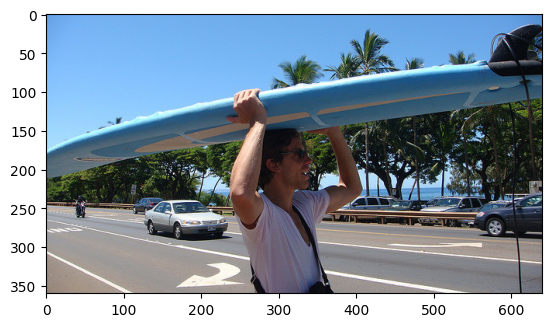

In [16]:
example_image_path = f'{HOME}/tmp/YOLOv5Dataset/images/train/000000577022.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [17]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

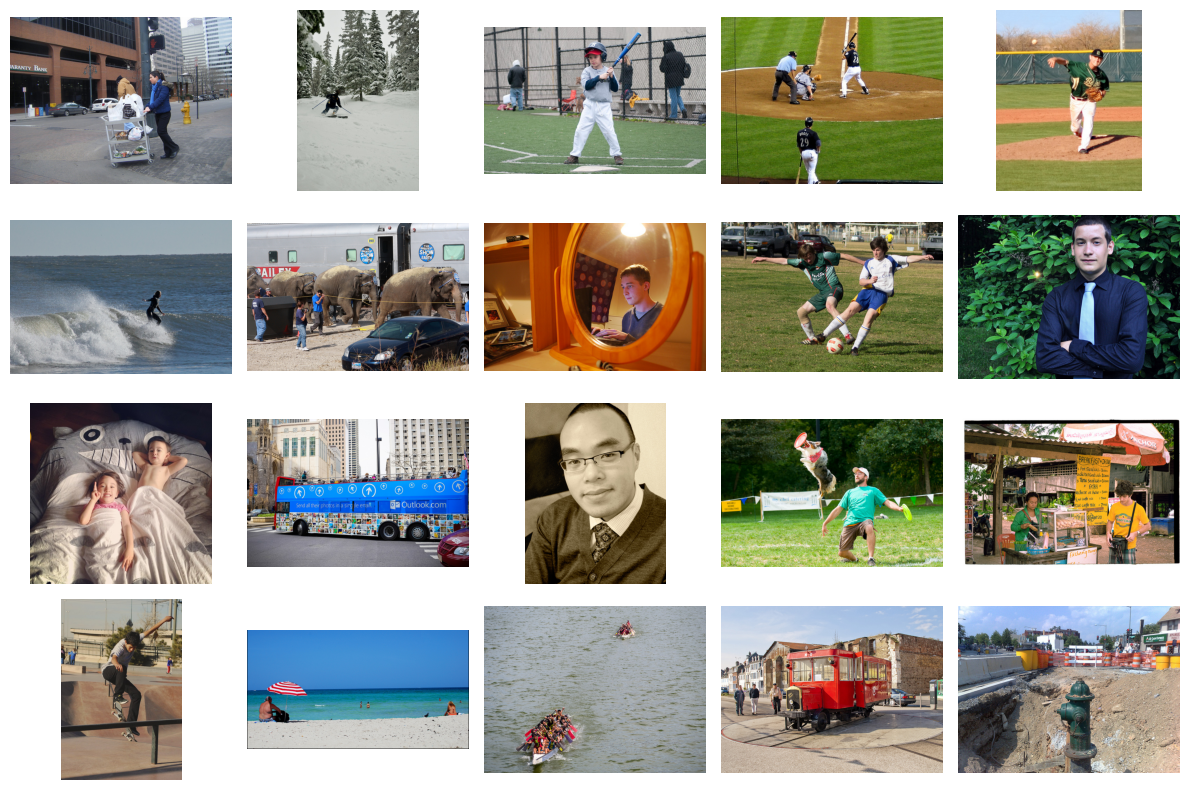

In [18]:
folder_path = CFG.CUSTOM_DATASET_DIR + '/images/train/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

In [19]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [20]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 360, 'channels': 3, 'dtype': dtype('uint8')}

In [21]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'validation']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, 'labels', mode)

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: user 130 ms, sys: 46.2 ms, total: 177 ms
Wall time: 178 ms


,Mode,person,Data_Volume
0,train,4000,4000
1,validation,500,500


In [22]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
    device = [0], # inference with dual GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

100%|██████████| 112M/112M [00:00<00:00, 325MB/s] 



WARNING ⚠️ imgsz=[360, 640] must be multiple of max stride 32, updating to [384, 640]
image 1/1 /kaggle/working/tmp/YOLOv5Dataset/images/train/000000577022.jpg: 384x640 2 persons, 39.0ms
Speed: 7.7ms preprocess, 39.0ms inference, 422.6ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (360, 640, 3) 



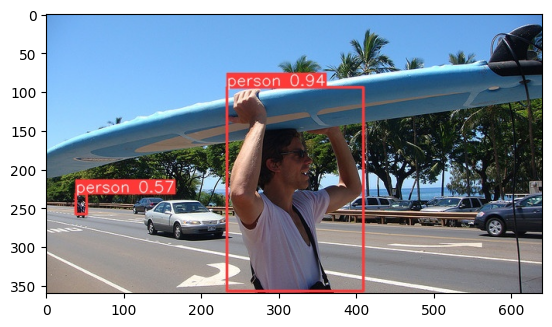

In [23]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'{HOME}/runs/detect/predict/{example_image_inference_output}')

## Train

In [38]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov9c.pt
Epochs:  70
Batch:  6


In [25]:
## Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [26]:
print(CFG.OUTPUT_DIR)

/kaggle/working/tmp/YOLOv5Dataset


In [49]:
import torch
torch.cuda.empty_cache()

# %%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'dataset.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = [0],
    verbose = False,
)

Ultralytics YOLOv8.1.42 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=/kaggle/working/tmp/YOLOv5Dataset/dataset.yaml, epochs=3, time=None, patience=20, batch=8, imgsz=(360, 640), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9c_person_detection_3_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False

train: Scanning /kaggle/working/tmp/YOLOv5Dataset/labels/train.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/tmp/YOLOv5Dataset/labels/validation.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov9c_person_detection_3_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolov9c_person_detection_3_epochs
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      13.1G      1.607      1.739      1.699         76        640: 100%|██████████| 500/500 [09:01<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]

                   all        500       2157      0.436      0.346      0.331      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      12.4G      1.622       1.75      1.706         34        640: 100%|██████████| 500/500 [08:40<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]


                   all        500       2157       0.48      0.401      0.405      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      12.3G      1.491      1.583      1.613         50        640: 100%|██████████| 500/500 [08:34<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

                   all        500       2157      0.597      0.512      0.539      0.311



3 epochs completed in 0.459 hours.
Optimizer stripped from runs/detect/yolov9c_person_detection_3_epochs/weights/last.pt, 117.2MB
Optimizer stripped from runs/detect/yolov9c_person_detection_3_epochs/weights/best.pt, 117.2MB

Validating runs/detect/yolov9c_person_detection_3_epochs/weights/best.pt...
Ultralytics YOLOv8.1.42 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
YOLOv9e summary (fused): 687 layers, 57377171 parameters, 0 gradients, 189.1 GFLOPs
WARNING ⚠️ renaming data YAML 'validation' key to 'val' to match YOLO format.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


                   all        500       2157        0.6      0.512      0.539      0.311
Speed: 0.1ms preprocess, 29.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/yolov9c_person_detection_3_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d8624843f70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### Train Result

In [51]:
results_paths = [
    i for i in
    glob.glob(f'{HOME}/runs/detect/yolov9c_person_detection_3_epochs/*.png') +
    glob.glob(f'{HOME}/runs/detect/yolov9c_person_detection_3_epochs*.jpg')
    if 'batch' not in i
]

results_paths

['/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/confusion_matrix_normalized.png',
 '/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/results.png',
 '/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/R_curve.png',
 '/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/confusion_matrix.png',
 '/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/P_curve.png',
 '/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/F1_curve.png',
 '/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/PR_curve.png']

/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/F1_curve.png


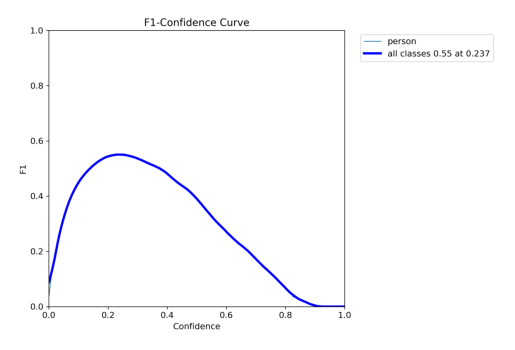



/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/PR_curve.png


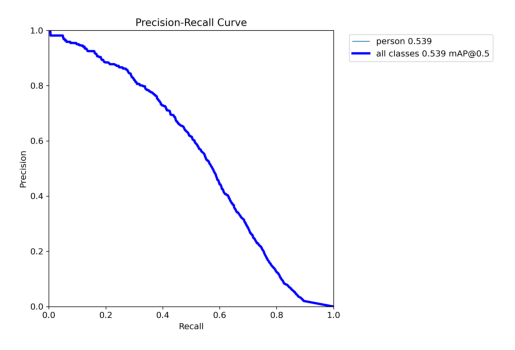



/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/P_curve.png


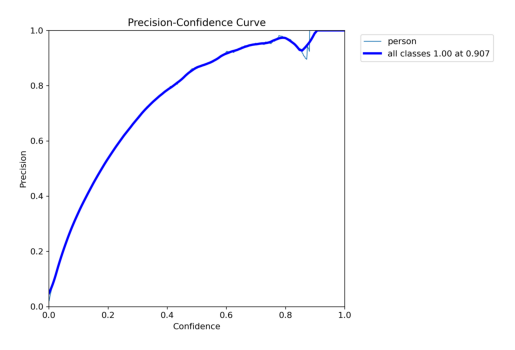



/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/R_curve.png


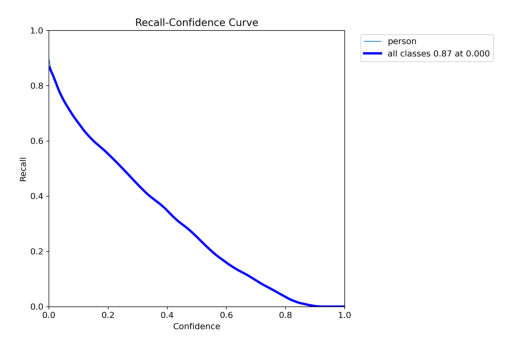



/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/confusion_matrix.png


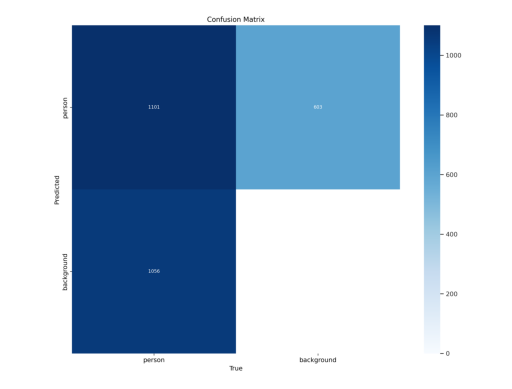



/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/confusion_matrix_normalized.png


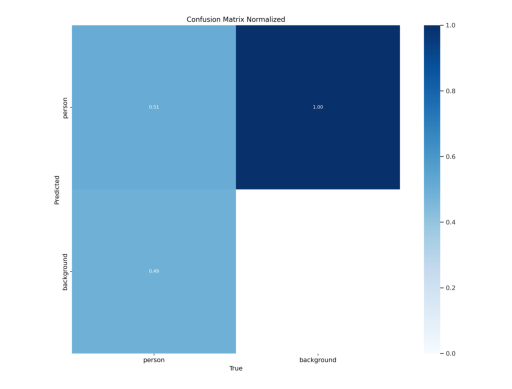



/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/results.png


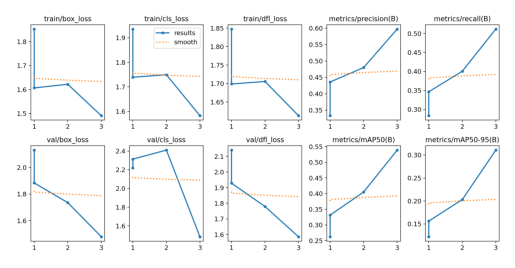

In [52]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [55]:
# {HOME}/runs/detect/yolov9c_person_detection_3_epochs/

df = pd.read_csv(f'{HOME}/runs/detect/yolov9c_person_detection_3_epochs/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{HOME}/runs/detect/yolov9c_person_detection_3_epochs/training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.8524,1.9359,1.8477,0.33329,0.28326,0.26228,0.12214,2.1298,2.2192,2.1400,0.000647,0.000647,0.000647
1,1,1.6067,1.7394,1.6989,0.43588,0.34631,0.33146,0.15621,1.8832,2.3135,1.9287,0.000665,0.000665,0.000665
2,2,1.6218,1.7496,1.7058,0.48006,0.40056,0.40521,0.20311,1.7355,2.4099,1.7793,0.000892,0.000892,0.000892
3,3,1.4908,1.5826,1.6131,0.59734,0.51182,0.53898,0.31072,1.4792,1.4837,1.5861,0.000680,0.000680,0.000680


In [56]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  1.4908 , on epoch:  4 


Best Validation Box loss:  1.4792 , on epoch:  4 


Best Training Cls loss:  1.5826 , on epoch:  4 


Best Validation Cls loss:  1.4837 , on epoch:  4 


Best Training DFL loss:  1.6131 , on epoch:  4 


Best Validation DFL loss:  1.5861 , on epoch:  4 



## Predict

In [57]:
model.export(format="onnx", opset=12, imgsz=[320, 320], int8=True)  # export the model to ONNX format

Ultralytics YOLOv8.1.42 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
YOLOv9e summary (fused): 687 layers, 57377171 parameters, 0 gradients, 189.1 GFLOPs

PyTorch: starting from 'runs/detect/yolov9c_person_detection_3_epochs/weights/best.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 5, 2100) (111.8 MB)

ONNX: starting export with onnx 1.15.0 opset 12...
ONNX: export success ✅ 8.8s, saved as 'runs/detect/yolov9c_person_detection_3_epochs/weights/best.onnx' (219.2 MB)

Export complete (11.0s)
Results saved to /kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9c_person_detection_3_epochs/weights/best.onnx imgsz=320 int8 
Validate:        yolo val task=detect model=runs/detect/yolov9c_person_detection_3_epochs/weights/best.onnx imgsz=320 data=/kaggle/working/tmp/YOLOv5Dataset/dataset.yaml int8 
Visualize:       https://netron.app


'runs/detect/yolov9c_person_detection_3_epochs/weights/best.onnx'

In [71]:
!pip install onnxruntime-gpu

In [72]:
!pip install skl2onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.5/298.5 kB 6.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 re

In [79]:
!python {HOME}/yolov9/detect.py \
--weights {HOME}/runs/detect/yolov9c_person_detection_3_epochs/weights/best.pt \
--conf 0.1 \
--source {HOME}/data/test/data/000000000552.jpg \
--device 0

detect: weights=['/kaggle/working/runs/detect/yolov9c_person_detection_3_epochs/weights/best.pt'], source=/kaggle/working/data/test/data/000000000552.jpg, data=../../../data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=../../../runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)

YOLOv9e summary (fused): 687 layers, 57377171 parameters, 0 gradients, 189.1 GFLOPs
image 1/1 /kaggle/working/data/test/data/000000000552.jpg: 448x640 1 person, 96.6ms
Speed: 0.4ms pre-process, 96.6ms inference, 333.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to ../../../runs/detect/exp8


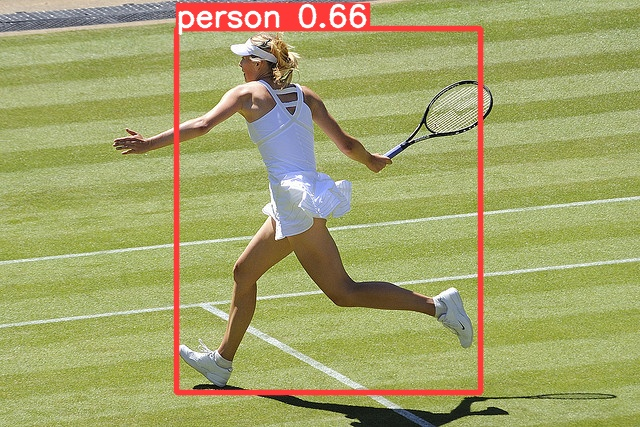

In [80]:
from IPython.display import Image
Image(filename=f"/kaggle/working/yolov9/runs/detect/exp8/000000000552.jpg", width=600)